# Overview

This notebook contains my solutions for **<a href="https://adventofcode.com/2024" target="_blank">Advent of Code 2024</a>**.

A few notes...
- The source for this notebook source lives in my GitHub repo, <a href="https://github.com/derailed-dash/Advent-of-Code/blob/master/src/AoC_2024/Dazbo's_Advent_of_Code_2024.ipynb" target="_blank">here</a>.
- You can run this Notebook wherever you like. For example, you could...
  - Run it locally, in your own Jupyter environment.
  - Run it in a cloud-based Jupyter environment, with no setup required on your part!  For example, with **Google Colab**: <br><br><a href="https://colab.research.google.com/github/derailed-dash/Advent-of-Code/blob/master/src/AoC_2024/Dazbo's_Advent_of_Code_2024.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Google Colab"/></a><br>
  - For more ways to run Jupyter Notebooks, check out [my guide](https://medium.com/python-in-plain-english/five-ways-to-run-jupyter-labs-and-notebooks-23209f71e5c0).
- **To run the notebook, execute the cells in the [Setup](#Setup) section, as described below. Then you can run the code for any given day.**
- Be mindful that the first time you run this notebook, you will need to **obtain your AoC session key** and store it, if you have not done so already. This allows the notebook to automatically retrieve your input data. (See the guidance in the **[Get Access to Your AoC Data](#Get-Access-to-Your-AoC-Data)** section for details.)
- Use the navigation menu on the left to jump to any particular day.
- All of my AoC solutions are documented in my <a href="https://aoc.just2good.co.uk/" target="_blank">AoC Python Walkthrough site</a>.

# Setup

You need to run all cells in this section, before running any particular day solution.

## Packages and Imports

Here we use `pip` to install the packages used by my solutions in this event. After installing the packages, you may need to restart your Jupyter kernel in order for the packages to be detected and remove any linting errors.

In [ ]:
%pip install --upgrade --no-cache-dir \
    jupyterlab-lsp ipykernel ipywidgets \
    matplotlib pandas networkx  sympy \
    dazbo-commons \
    colorama python-dotenv tqdm

In [ ]:
from __future__ import annotations
from concurrent.futures import ProcessPoolExecutor
import ast
import copy
import heapq
import logging
import math
import operator
import os
import platform
import re
from collections import Counter, deque, defaultdict, namedtuple
from dataclasses import asdict, dataclass, field
from enum import Enum, auto
from functools import cache, reduce
from itertools import combinations, count, cycle, permutations, product
from getpass import getpass
from pathlib import Path

# Third-party imports
import dazbo_commons as dc  # my own utility library, which includes things like coloured logging
import requests
import sympy
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import networkx as nx
import numpy as np
import pandas as pd
from colorama import Fore, Back, Style
from dotenv import load_dotenv
from IPython.core.display import Markdown
from IPython.display import display
from tqdm.notebook import tqdm

## Logging and Output

Set up a new logger that uses `ColouredFormatter`, such that we have coloured logging.  The log colour depends on the logging level.

In [ ]:
# Setup logger
YEAR = 2024
APP_NAME = "aoc" + str(YEAR)
logger = dc.retrieve_console_logger(APP_NAME)
logger.setLevel(logging.DEBUG)
logger.info("Logger initialised.")
logger.debug("Debugging enabled")

## Install Packages

- [ffmpeg](https://ffmpeg.org/): in order to render video output, i.e. for visualisations.
- graphviz: for visualising graphs

In [ ]:
import subprocess

def run_command(command):
    """Run a shell command and print its output in real-time."""
    process = subprocess.Popen(
        command, 
        shell=True, 
        stdout=subprocess.PIPE, 
        stderr=subprocess.PIPE
    )
    
    # Read and print the output line by line
    if process.stdout is not None:
        for line in iter(process.stdout.readline, b''):
            logger.info(line.decode().strip())
        process.stdout.close()
        
    process.wait()
    
def install_software(appname: str):
    os_name = platform.system()
    logger.info(f"Installing {appname} on {os_name}...")
    
    # Mapping operating systems to their respective installation commands
    command_map = {
        "Windows": f"winget install {appname} --silent --no-upgrade",
        "Linux": f"apt -qq -y install {appname}",
        "Darwin": f"brew install {appname}"
    }
    command = command_map.get(os_name)
    if command:
        run_command(command)
    else:
        logger.error(f"Unsupported operating system: {os_name}")

def check_installed(app_exec: str) -> bool:    
    appname, *arg = app_exec.split()
    arg = " ".join(arg)
    logger.debug(f"Checking if {appname} is installed")
    
    try:
        output = subprocess.check_output([appname, arg], stderr=subprocess.STDOUT)
        logger.debug(f"{appname} version: {output.decode().strip()}")
        logger.debug(f"{appname} is already installed.")
        return True
    except (subprocess.CalledProcessError, FileNotFoundError):
        logger.debug(f"{appname} is not installed or absent from path.")
        
    return False

apps = [ ("ffmpeg", "ffmpeg -version"),
         ("graphviz", "dot --version") ]
          
for app_install, app_exec in apps:
    if not check_installed(app_exec):
        install_software(app_install)

## Load Helpers and Useful Classes

Now we load a bunch of helper functions and classes.

### Locations

Where any input and output files get stored.

<img src="https://aoc.just2good.co.uk/assets/images/notebook-content-screenshot.png" width="320" />


### Retrieve the Input Data

This works by using your unique session cookie to retrieve your input data. E.g. from a URL like:

`https://adventofcode.com/2024/day/1/input`

In [ ]:
##################################################################
# Retrieving input data
##################################################################

def write_puzzle_input_file(year: int, day, locations: dc.Locations):
    """ Use session key to obtain user's unique data for this year and day.
    Only retrieve if the input file does not already exist.
    Return True if successful.
    Requires env: AOC_SESSION_COOKIE, which can be set from the .env.
    """
    if os.path.exists(locations.input_file):
        logger.debug("%s already exists", os.path.basename(locations.input_file))
        return os.path.basename(locations.input_file)

    session_cookie = os.getenv('AOC_SESSION_COOKIE')
    if not session_cookie:
        raise ValueError("Could not retrieve session cookie.")

    logger.info('Session cookie retrieved: %s...%s', session_cookie[0:6], session_cookie[-6:])

    # Create input folder, if it doesn't exist
    if not locations.input_dir.exists():
        locations.input_dir.mkdir(parents=True, exist_ok=True)

    url = f"https://adventofcode.com/{year}/day/{day}/input"
    
    # Don't think we need to set a user-agent
    # headers = {
    #     "User-Agent": 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36'
    # }
    cookies = { 
        "session": session_cookie
    }
    response = requests.get(url, cookies=cookies, timeout=5)

    data = ""
    if response.status_code == 200:
        data = response.text

        with open(locations.input_file, 'w') as file:
            logger.debug("Writing input file %s", os.path.basename(locations.input_file))
            file.write(data)
            return data
    else:
        raise ValueError(f"Unable to retrieve input data.\n" +
                         f"HTTP response: {response.status_code}\n" +
                         f"{response.reason}: {response.content.decode('utf-8').strip()}")
        
def show_day_link(day):
    day_link = f"#### See [Day {day}](https://adventofcode.com/{YEAR}/day/{day})."
    display(Markdown(day_link))


### Testing

A really simple function for testing that our solution produces the expected test output. If the `validate()` call fails, then execution will stop.

In [ ]:
def validate(test, answer):
    """
    Args:
        test: the answer given by our solution
        answer: the expected answer, e.g. from instructions
    """
    if test != answer:
        raise AssertionError(f"{test} != {answer}")

### Useful Helper Classes

In [ ]:
#################################################################
# POINTS, VECTORS AND GRIDS
#################################################################

Point = namedtuple("Point", ["x", "y"])

Point.__add__ = lambda self, other: Point(self.x + other.x, self.y + other.y)
Point.__sub__ = lambda self, other: Point(self.x - other.x, self.y - other.y) 

def yield_neighbours(self, include_diagonals=True, include_self=False):
    """ Generator to yield neighbouring Points """

    deltas: list
    if not include_diagonals:
        deltas = [vector.value for vector in Vectors if abs(vector.value.x) != abs(vector.value.y)]
    else:
        deltas = [vector.value for vector in Vectors]

    if include_self:
        deltas.append(Point(0, 0))

    for delta in deltas:
        yield self + delta

def neighbours(self, include_diagonals=True, include_self=False):
    return list(yield_neighbours(self, include_diagonals, include_self))

def get_specific_neighbours(self, directions):
    return [self + vector.value for vector in list(directions)]

def manhattan_distance(a_point: Point):
    return sum(abs(coord) for coord in asdict(a_point).values())

def manhattan_distance_from(self, other):
    diff = self - other
    return manhattan_distance(diff)

Point.yield_neighbours = yield_neighbours
Point.neighbours = neighbours
Point.get_specific_neighbours = get_specific_neighbours
Point.manhattan_distance = staticmethod(manhattan_distance)
Point.manhattan_distance_from = manhattan_distance_from
Point.__repr__ = lambda self: f"P({self.x},{self.y})" 

class Vectors(Enum):
    """ Enumeration of 8 directions.
    Note: y axis increments in the North direction, i.e. N = (0, 1) """
    N = Point(0, 1)
    NE = Point(1, 1)
    E = Point(1, 0)
    SE = Point(1, -1)
    S = Point(0, -1)
    SW = Point(-1, -1)
    W = Point(-1, 0)
    NW = Point(-1, 1)

    @property
    def y_inverted(self):
        """ Return vector, but with y-axis inverted. I.e. N = (0, -1) """
        x, y = self.value
        return Point(x, -y)

class VectorDicts():
    """ Contains constants for Vectors """
    ARROWS = {
        '^': Vectors.N.value,
        '>': Vectors.E.value,
        'v': Vectors.S.value,
        '<': Vectors.W.value
    }

    DIRS = {
        'U': Vectors.N.value,
        'R': Vectors.E.value,
        'D': Vectors.S.value,
        'L': Vectors.W.value
    }

    NINE_BOX: dict[str, tuple[int, int]] = {
        # x, y vector for adjacent locations
        'tr': (1, 1),
        'mr': (1, 0),
        'br': (1, -1),
        'bm': (0, -1),
        'bl': (-1, -1),
        'ml': (-1, 0),
        'tl': (-1, 1),
        'tm': (0, 1)
    }

class Grid():
    """ 2D grid of point values. """
    def __init__(self, grid_array: list) -> None:
        self._array = [list(row) for row in grid_array.copy()]
        self._width = len(self._array[0])
        self._height = len(self._array)
        
        self._all_points = [Point(x,y) for y in range(self._height) for x in range(self._width)]

    def value_at_point(self, point: Point):
        """ The value at this point """
        return self._array[point.y][point.x]

    def set_value_at_point(self, point: Point, value):
        self._array[point.y][point.x] = value

    def valid_location(self, point: Point) -> bool:
        """ Check if a location is within the grid """
        if (0 <= point.x < self._width and  0 <= point.y < self._height):
            return True

        return False

    @property
    def width(self):
        """ Array width (cols) """
        return self._width

    @property
    def height(self):
        """ Array height (rows) """
        return self._height

    def all_points(self) -> list[Point]:
        return self._all_points

    def rows_as_str(self):
        """ Return the grid """
        return ["".join(str(char) for char in row) for row in self._array]

    def cols_as_str(self):
        """ Render columns as str. Returns: list of str """
        cols_list = list(zip(*self._array))
        return ["".join(str(char) for char in col) for col in cols_list]

    def __repr__(self) -> str:
        return f"Grid(size={self.width}*{self.height})"

    def __str__(self) -> str:
        return "\n".join("".join(map(str, row)) for row in self._array)

### Useful Helper Functions

In [ ]:
#################################################################
# CONSOLE STUFF
#################################################################

def cls():
    """ Clear console """
    os.system('cls' if os.name=='nt' else 'clear')

#################################################################
# USEFUL FUNCTIONS
#################################################################

def binary_search(target, low:int, high:int, func, *func_args, reverse_search=False):
    """ Generic binary search function that takes a target to find,
    low and high values to start with, and a function to run, plus its args.
    Implicitly returns None if the search is exceeded. """

    res = None  # just set it to something that isn't the target
    candidate = 0  # initialise; we'll set it to the mid point in a second

    while low < high:  # search exceeded
        candidate = int((low+high) // 2)  # pick mid-point of our low and high
        res = func(candidate, *func_args) # run our function, whatever it is
        logger.debug("%d -> %d", candidate, res)
        if res == target:
            return candidate  # solution found

        comp = operator.lt if not reverse_search else operator.gt
        if comp(res, target):
            low = candidate
        else:
            high = candidate

def merge_intervals(intervals: list[list]) -> list[list]:
    """ Takes intervals in the form [[a, b][c, d][d, e]...]
    Intervals can overlap.  Compresses to minimum number of non-overlapping intervals. """
    intervals.sort()
    stack = []
    stack.append(intervals[0])

    for interval in intervals[1:]:
        # Check for overlapping interval
        if stack[-1][0] <= interval[0] <= stack[-1][-1]:
            stack[-1][-1] = max(stack[-1][-1], interval[-1])
        else:
            stack.append(interval)

    return stack

@cache
def get_factors(num: int) -> set[int]:
    """ Gets the factors for a given number. Returns a set[int] of factors.
        # E.g. when num=8, factors will be 1, 2, 4, 8 """
    factors = set()

    # Iterate from 1 to sqrt of 8,
    # since a larger factor of num must be a multiple of a smaller factor already checked
    for i in range(1, int(num**0.5) + 1):  # e.g. with num=8, this is range(1, 3)
        if num % i == 0: # if it is a factor, then dividing num by it will yield no remainder
            factors.add(i)  # e.g. 1, 2
            factors.add(num//i)  # i.e. 8//1 = 8, 8//2 = 4

    return factors

def to_base_n(number: int, base: int):
    """ Convert any integer number into a base-n string representation of that number.
    E.g. to_base_n(38, 5) = 123

    Args:
        number (int): The number to convert
        base (int): The base to apply

    Returns:
        [str]: The string representation of the number
    """
    ret_str = ""
    curr_num = number
    while curr_num:
        ret_str = str(curr_num % base) + ret_str
        curr_num //= base

    return ret_str if number > 0 else "0"


# Env Clear

Only run the next cell if you want to manually clear your session key.

In [ ]:
del os.environ['AOC_SESSION_COOKIE']

# Days

Here you'll find a template to build a solution for a given day, and then the solutions for all days in this event.

To copy the template day, select all the cells in the `Day n` template, add a new cell at the end, and then paste the cells there.

---
## Day 1: Historian Hysteria

In [ ]:
DAY = "1" # replace with actual number (without leading digit)
show_day_link(DAY)

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2024d01
locations = dc.get_locations(d_name)
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", dc.top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 1 Part 1

We're told: historically significant locations are listed by a unique number called the location ID. The Historians have split into two groups, and each group has created their own list of locations.

Our puzzle input is the two lists; i.e. presented as two columns of numbers. We need to reconcile the differences. E.g.

```text
3   4
4   3
2   5
1   3
3   9
3   3
```

Goal:

- Pair the smallest number in the two lists, and measure the difference.
- Then the second smallest number from each list, and so on.
- Return the sum of differences.

**What is the total distance between your lists?**

#### Solution Approach

1. Build two lists by splitting each line into two numbers. We can easily do this by [reading each line](https://aoc.just2good.co.uk/python/reading_files), and calling the `split()` function, which automatically splits on the whitespace between the numbers. For each row, we now end up with two numbers, but returned as string values. So we use [map()](https://aoc.just2good.co.uk/python/map-filter-reduce) to turn the strings into integer types. Now we have a pair of integer numbers for each line, which we wrap in a tuple and return in a [list comprehension](https://aoc.just2good.co.uk/python/comprehensions). I.e. one list containing tuples, which are each a pair of integers. Finally, we use the [zip()](https://aoc.just2good.co.uk/python/zip) function to turn the list of tuples pairs into a pair of lists: one list for left column, and one list for the right column.
1. Sort the two lists, such that the smallest number in each column comes first, and so on.
1. Find the absolute difference between each pair of numbers, and sum these differences.

In [ ]:
@cache
def process_data(data) -> tuple[list[int], list[int]]:
    items = [tuple(map(int, line.split())) for line in data] # returns list of tuples, e.g. [(3, 5), ...]
    list1, list2 = zip(*items) # list of all lefts, plus list of all rights
    return sorted(list1), sorted(list2)

def solve_part1(data) -> int:
    list1, list2 = process_data(tuple(data))
    
    diff = 0
    for item1, item2 in zip(list1, list2):
        diff += abs(item2 - item1)
        
    return diff

In [ ]:
%%time
sample_inputs = []
sample_inputs.append("""\
3   4
4   3
2   5
1   3
3   9
3   3
""")
sample_answers = [11]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part1(curr_input.splitlines()), curr_ans) # test with sample data
    logger.info("Test passed")

logger.info("All tests passed!")

soln = solve_part1(input_data)
logger.info(f"Part 1 soln={soln}")

### Day 1 Part 2

Figure out exactly how often each number from the left list appears in the right list. Calculate a total similarity score by adding up each number in the left list after multiplying it by the number of times that number appears in the right list.

**What is their similarity score?**

#### Solution Approach

1. For each item in list1, count how many times it appears in list2.
1. Add the product of the item and the count to our score.


In [ ]:
def solve_part2(data):
    list1, list2 = process_data(tuple(data))
    
    score = 0
    for item in list1:
        item_count = list2.count(item)
        score += item * item_count
        
    return score

In [ ]:
%%time

sample_answers = [31]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part2(curr_input.splitlines()), curr_ans) # test with sample data
    logger.info("Test passed")    

logger.info("Tests passed!")

soln = solve_part2(input_data)
logger.info(f"Part 2 soln={soln}")

### Alternative Solutions

We could also solve using [Numpy](https://aoc.just2good.co.uk/python/numpy). This will be more efficient for large arrays.

In [ ]:
def solve(data) -> int:
    sorted_lists = process_data(tuple(data))
    
    # Create two Numpy arrays
    list1 = np.array(sorted_lists[0])
    list2 = np.array(sorted_lists[1])
    
    diff = np.sum(np.abs(list2-list1)) # The sum of item diffs
    logger.info(f"{diff=}")
    
    similarity_score = 0
    for item in list1:
        item_count = (list2 == item).sum() # How many times the item appears in list2
        similarity_score += item * item_count
        
    logger.info(f"{similarity_score=}")
    
solve(input_data)

---
## Day 2: Red-Nosed Reports

In [ ]:
DAY = "2" # replace with actual number (without leading digit)
show_day_link(DAY)

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2024d01
locations = dc.get_locations(d_name)
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", dc.top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 2 Part 1

Our data is a set of reports. Each line is one report. Each report contains a list of numbers called levels. Like this:

```text
7 6 4 2 1
1 2 7 8 9
9 7 6 2 1
1 3 2 4 5
8 6 4 4 1
1 3 6 7 9
```

Reports are safe if:

- The levels are either all increasing or all decreasing
- And any two adjacent levels must differ by at least 1 and at most 3.

**How many reports are safe?**

#### Solution Approach

- Split each record into a list of int values, called `levels`.
- Create `is_safe()` function which:
  - Creates a list of difference values - called `diffs` - by subtracting `levels` with offset 1 from `levels`.
  - Then, use the `all` iterator operator function to check if our condition is true for every diff in `diffs`.
  - The condition is: that every diff is positive and `<=MAX_DIFF` or every diff is negative and `>=MAX_DIFF`.

In [ ]:
def is_safe(levels: list[int], max_diff: int) -> bool:
    """ Determine if a record - i.e. a list of levels - is safe.
    Do this by determining the differences between each level in the record.
    Check if the differences are all positive and within the max, 
    or all negative and within the max. """
    
    # Create pairs of levels from successive levels
    # For each pair, substract second from first to get the difference
    diffs = [first-second for first, second in zip(levels, levels[1:])]
    
    return (all(0 < diff <= max_diff for diff in diffs) or 
            all(-max_diff <= diff < 0 for diff in diffs))

def solve_part1(data):
    safe_count = 0
    for report in data:
        levels = list(map(int, report.split()))
        if is_safe(levels, 3):
            safe_count += 1
    
    return safe_count

In [ ]:
%%time
sample_inputs = []
sample_inputs.append("""\
7 6 4 2 1
1 2 7 8 9
9 7 6 2 1
1 3 2 4 5
8 6 4 4 1
1 3 6 7 9""")
sample_answers = [2]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part1(curr_input.splitlines()), curr_ans) # test with sample data
    logger.info("Test passed")

logger.info("All tests passed!")

soln = solve_part1(input_data)
logger.info(f"Part 1 soln={soln}")

### Day 2 Part 2

We now have a _Problem Dampener_, which means we can tolerate a single bad level in any given record.

So we must try removing levels from records, and then testing if the report is safe.

**How many reports are now safe?**

#### Solution Approach

Same as before, but this time we will iterate through the index values of each record, and remove that level from the record. I.e.

- Loop through each index value for the record.
- For the current index value, concatenate the levels up to this index with the levels after this index. Thus, we always end up with a list that is one shorter than the original list. (Note that trimming off the first or last level will never make a safe record _unsafe_.)
- Pass shortened list to our `is_safe()` function.
- If the shortened record is safe, then we can add this record to our counter and move on to the next record.

In [ ]:
def solve_part2(data):
    safe_count = 0
    for report in data:
        levels = list(map(int, report.split()))

        # Slice out one level at a time, and check if the new record is safe
        for idx in range(len(levels)):
            # Take levels up this idx, and concatenate with levels AFTER this idx
            trimmed_levels = levels[:idx] + levels[idx+1:]
            if is_safe(trimmed_levels, 3):
                safe_count += 1
                break
    
    return safe_count

In [ ]:
%%time
sample_inputs = []
sample_inputs.append("""\
7 6 4 2 1
1 2 7 8 9
9 7 6 2 1
1 3 2 4 5
8 6 4 4 1
1 3 6 7 9""")
sample_answers = [4]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part2(curr_input.splitlines()), curr_ans) # test with sample data
    logger.info("Test passed")

logger.info("Tests passed!")

soln = solve_part2(input_data)
logger.info(f"Part 2 soln={soln}")

---
## Day 3: Mull It Over

In [ ]:
DAY = "3" # replace with actual number (without leading digit)
show_day_link(DAY)

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2024d01
locations = dc.get_locations(d_name)
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read()

    logger.info("Input data:\n%s", dc.top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 3 Part 1

A shop computer is trying to run a program, but its memory - the puzzle input - is corrupted.

It should be doing instructions like:

- `mul(X,Y)` where `X` and `Y` are 1-3 digit numbers.

Our instructions:

- There are many invalid characters which should be ignored.
- If an invalid character is part of a `mul()` instruction, then the whole instruction does nothing.
- Scan the corrupted memory for uncorrupted mul instructions.

**What do you get if you add up all of the results of the multiplications?**

#### Solution Approach

We can just use [regex](https://aoc.just2good.co.uk/python/regex).

- Use a regex pattern to identify substrints that match the required input format.
- Use the regex `finditer()` to retrieve all non-overlapping matches.
- The `matches.groups()` retrieves the captured groups, i.e. the digits themselves. We identify capture groups by placing each digit in brackets in the pattern string.
- Then, multiply the two digits together, as required.

In [ ]:
def solve_part1(data):
    # match all "mul(x,y)"
    matches = re.finditer(r"mul\((\d{1,3}),(\d{1,3})\)", data)
    
    ans = 0
    for match in matches:
        val_x, val_y = match.groups()
        ans += int(val_x)*int(val_y)
        
    return ans


In [ ]:
%%time
sample_inputs = []
sample_inputs.append("""xmul(2,4)%&mul[3,7]!@^do_not_mul(5,5)+mul(32,64]then(mul(11,8)mul(8,5))""")
sample_answers = [161]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part1(curr_input), curr_ans) # test with sample data
    logger.info("Test passed")

logger.info("All tests passed!")

soln = solve_part1(input_data)
logger.info(f"Part 1 soln={soln}")

### Day 3 Part 2

Now we also want to handle intact conditional statements. We need to handle:

- `do()` which enables future `mul` instructions
- `don't()` which disables future `mul` instructions.

We start enabled.

**What is the sum of just the enabled multiplications?**

#### Solution Approach

- Okay, we start `enabled`.
- Whilst `enabled==True`, everything up to the next `don't()` should be parsed for `mul()` instructions.
- When we hit a `don't()`, we set `enabled=False`.
- Now, everything up to the next `do()` should be ignored.
- When we hit a `do()`, we set `enabled=True` again.

I'm shocked... This worked first time with no bugs!!

In [ ]:
def solve_part2(data: str):
    # match all "mul(x,y)"
    matcher = re.compile(r"mul\((\d{1,3}),(\d{1,3})\)")
    
    remaining_program = data
    enabled = True # We start enabled
    ans = 0
    while remaining_program:
        if enabled:
            # split into the part before the next "don't()", and everything afterwards
            this_part, _, remaining_program = remaining_program.partition(r"don't()")
        
            for match in matcher.finditer(this_part):
                val_x, val_y = match.groups()
                ans += int(val_x)*int(val_y)
            
            enabled = False
        else:
            # split into the part before the next "do()", and everything afterwards
            this_part, _, remaining_program = remaining_program.partition(r"do()")
            enabled = True
        
    return ans

In [ ]:
%%time
sample_inputs = []
sample_inputs.append("""xmul(2,4)&mul[3,7]!^don't()_mul(5,5)+mul(32,64](mul(11,8)undo()?mul(8,5))""")
sample_answers = [48]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part2(curr_input), curr_ans) # test with sample data
    logger.info("Test passed")    

logger.info("Tests passed!")

soln = solve_part2(input_data)
logger.info(f"Part 2 soln={soln}")

---
## Day 4: Ceres Search

In [ ]:
DAY = "4" # replace with actual number (without leading digit)
show_day_link(DAY)

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2024d01
locations = dc.get_locations(d_name)
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", dc.top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 4 Part 1

We have a word search! We need to find every instance of the word `XMAS`. The string can be found horizontally, vertically, diagonally, and in forward/reverse directions.

#### Solution Approach

- Create a dictinary to count how many times a given character is part of a matched word. Why did I do this?
  - Firstly, we can use this dictionary to determine if any given character in the grid has been matched in a word. This makes it easy to print a grid that only shows matched characters. Useful for debugging!
  - Secondly, I thought Part 2 might be asking where we have characters that are matched more than once, i.e. where words cross. This dict would have made it super easy for me to determine that. Alas, my guess was wrong!
- Now move through each location in the grid, and stop whenever we find the `X` of `XMAS`.
- Having identified the starting `X`, now iterate through all 8 possible directions.
- For each direction, first determine if the full word can fit in the grid, i.e. that we don't get cut off by a grid edge.
- If the word can fit, we then move one char at a time in the current direction, and test if the characters match the remaining characters in our word. 
- If all characters match, then we've matched the word and we can increment that `matches` counter.  But also, increment the counts for each character in this word.
- Now, render a visualisation of the grid, showing a `.` whenever the count at this location is 0, else show the character at this location.#
- Finally, return the total number of `matches`.


In [ ]:
def solve_part1(data):
    match_word = "XMAS"
    matched_posn_counts = defaultdict(int) # increment whenever this index is in a matched word

    grid_width = len(data[0])
    grid_height = len(data)

    matches = 0

    # Iterate through all positions in the grid
    for row_idx in range(grid_height):
        for col_idx in range(grid_width):
            # Find the X (first char)
            if data[row_idx][col_idx] == match_word[0]:
                # Now we want to expand in all directions
                for direction in Vectors: # Loop through all directions

                    # Check if the full word can be within the grid bounds
                    chars_left = len(match_word)-1
                    if not (0 <= (col_idx + chars_left*direction.value[0]) < grid_width):
                        continue # try next direction
                    if not (0 <= (row_idx + chars_left*direction.value[1]) < grid_height):
                        continue # try next direction

                    found_word = True

                    # Test remaining letters in this direction
                    for steps, char in enumerate(match_word[1:], start=1):
                        new_row_idx = row_idx + steps*direction.value[1]
                        new_col_idx = col_idx + steps*direction.value[0]
                        if data[new_row_idx][new_col_idx] != char:
                            found_word = False
                            break

                    if found_word:
                        # Mark these all word locations as matched
                        for steps, char in enumerate(match_word):
                            new_row_idx = row_idx + steps*direction.value[1]
                            new_col_idx = col_idx + steps*direction.value[0]
                            matched_posn_counts[(new_col_idx, new_row_idx)] += 1
                        
                        matches += 1
    
    grid_rows = []
    for row_idx in range(grid_height):
        row_str = ""
        for col_idx in range(grid_width):
            row_str += data[row_idx][col_idx] if matched_posn_counts[(col_idx, row_idx)] > 0 else "."
        
        grid_rows.append(row_str)
    
    grid_vis = "\n".join(grid_rows)
    logger.info(f"\n{grid_vis}")

    return matches
    


%%time
sample_inputs = []
sample_inputs.append("""\
MMMSXXMASM
MSAMXMSMSA
AMXSXMAAMM
MSAMASMSMX
XMASAMXAMM
XXAMMXXAMA
SMSMSASXSS
SAXAMASAAA
MAMMMXMMMM
MXMXAXMASX""")
sample_answers = [18]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part1(curr_input.splitlines()), curr_ans) # test with sample data
    logger.info("Test passed")

logger.info("All tests passed!")

soln = solve_part1(input_data)
logger.info(f"Part 1 soln={soln}")
### Day 4 Part 2

Quite different for part 2! Now we need to find any any X shape that contains "MAS" twice. E.g. a configuration like this:

```text
M.S
.A.
M.S
```

Observations:

- The centre character will always be `A`.
- The `M` and `S` characters each need to appear twice in the X.
- The `MAS` must be spelled diagonally. So if `M` is in one corner, then `S` will be in the opposite corner.

#### Solution Approach

- Set up a moveable X grid, by storing a list of vectors that represent the corners: NE, SE, SW, NW.
- Move the X through every possible location in the grid. We'll start by matching the `A` at the centre of the grid. For this reason, we should start at position `(1, 1)`, we will we will always stop one row / column before any given edge.
- Having matched an `A`, determine the coordinates of the four corners.
- Check that the four corners contain each remaining character (i.e. `M` or `S`) twice. If so, this location is a candidate.
- If we've found a candidate, determine the char in the top-right corner. Then determine if the char in the bottom-left corner is the _other_ end character in our word. If it is, then we've got a match. Why? Because if we've verified this diagonal, then by previously verifying the character counts, we know that the other diagonal is also satisfied.

And that's it! It's really quick too!

In [ ]:
def solve_part2(data):
    match_word = "MAS"
    center = match_word[1] # `A`
    ends = match_word[0] + match_word[-1] # `MS`

    grid_width = len(data[0])
    grid_height = len(data)

    matches = 0

    corner_vecs = [Vectors.NE.value,
                   Vectors.SE.value,
                   Vectors.SW.value,
                   Vectors.NW.value]

    # Traverse the grid, but always inset by 1
    for row_num in range(1, grid_height-1):
        for col_num in range(1, grid_width-1):
            current_centre = data[row_num][col_num]
            # Does middle of the X contain the A of "MAS"?
            if current_centre == center:
                corners = [(col_num+dx, row_num+dy) for dx, dy in corner_vecs]
                corner_chars = [data[y][x] for x, y in corners]

                # Check that each end char appears in the X exactly twice
                if all(corner_chars.count(char) == 2 for char in ends):
                    # if top right char is the opposite end char to bottom left char, we're matched
                    tr_char = data[corners[0][1]][corners[0][0]]
                    bl_char = data[corners[2][1]][corners[2][0]]
                    tr_match_idx = ends.index(tr_char)
                    if bl_char == ends[(len(ends)-tr_match_idx)-1]:
                        matches += 1

    return matches

In [ ]:
%%time
sample_inputs = []
sample_inputs.append("""\
MMMSXXMASM
MSAMXMSMSA
AMXSXMAAMM
MSAMASMSMX
XMASAMXAMM
XXAMMXXAMA
SMSMSASXSS
SAXAMASAAA
MAMMMXMMMM
MXMXAXMASX""")
sample_answers = [9]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part2(curr_input.splitlines()), curr_ans) # test with sample data
    logger.info("Test passed")    

logger.info("Tests passed!")

soln = solve_part2(input_data)
logger.info(f"Part 2 soln={soln}")

---
## Day 5: Print Queue

In [ ]:
DAY = "5" # replace with actual number (without leading digit)
show_day_link(DAY)

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2024d01
locations = dc.get_locations(d_name)
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read()

    logger.info("Input data:\n%s", dc.top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 5 Part 1

Out input is in two blocks:

1. The page order rules - one rule per line. These are pairs of rules, e.g. `47|53`. This means that `if` an update contains *both* of these page numbers, then page `47` must be printed at some point *before* `53`.
1. The specified page numbers required in a particular update - one update set per line.

The sample input:

```text
47|53
97|13
97|61
97|47
75|29
61|13
75|53
29|13
97|29
53|29
61|53
97|53
61|29
47|13
75|47
97|75
47|61
75|61
47|29
75|13
53|13

75,47,61,53,29
97,61,53,29,13
75,29,13
75,97,47,61,53
61,13,29
97,13,75,29,47
```

**What is the sum of middle page numbers from only the updates are correctly ordered?**

#### Observations

Rules for a given update:

- For any page number N, there must NOT be a rule `B|N` for any `B` that comes AFTER it.
- For any page number N, there must NOT be a rule `N|A` for any `A` that comes BEFORE it.

Notes:

- The rules appear to be a complete set, meaning that there wil be a rule for _every_ possible pair of pages. Or, to put it another way: if `A|B` and `B|C`, then there will always be a rule `A|C`. This rule will be provided; we do not have to derive it implicitly.
- A given update does necessarily include every page and therefore does not need to include every rule.

#### Solution Approach

- For some reason, I just felt like a class would be a neater way to manage our rules and updates, so I've gone with a `PageOrdering` class.
- This includes a `_process_data()` method, which takes in the puzzle data and:
  - Splits into two blocks - the first block for the rules and the second block for the updates.
  - For the rules, I create `required_before` and `required_after` [defaultdicts](https://aoc.just2good.co.uk/python/defaultdict), of type list.
  - Every time we find a number on the left of the rule, we add the number on the right to the corresponding `required_after` list.
  - Every time we find a number on the right of the rule, we add the number on the left to the corresponding `required_before` list.
  - For the updates, I turn each line into a list of int values.
- Next, the `_is_correctly_ordered(update)` method. This is the heart of the Part 1 solution. We:
  - Iterate through each position for a given update.
  - For a given position we build up a set of all the pages that were found before it, and all the pages found after it.
  - Now get the set of all pages that are required before our page, and the set of all pages that are required after our page.
  - Finally, we can just use the [set](https://aoc.just2good.co.uk/python/sets) `intersect()` (shorthand of `&`) to determine if any of the pages found before are required after, and if any of the pages found after are required before. In either case, our update is NOT correctly ordered.
- Then implement `get_updates_correctly_ordered()`, which loops through each update and checks it using the method above.
- Finally, we'll create `sum_middles()` which takes a list of updates, and adds up the middle value from each one.

That's it!

In [ ]:
class PageOrdering():
    
    def __init__(self, data: str) -> None:
        
        required_after, required_before, updates = self._process_data(data)
        self._required_after = required_after
        self._required_before = required_before
        self._updates = updates
    
    @property
    def updates(self):
        return self._updates

    def _process_data(self, data: str):
        """ Parse input data to determine rules and updates """
        required_after = defaultdict(set)
        required_before = defaultdict(set)
        updates = [] 
        
        # split into blocks.
        rules_block, updates_block = data.split("\n\n") 
        
        # build two-way adjacency dictionary
        for rule in rules_block.splitlines():
            x, y = list(map(int, rule.split("|")))
            required_after[x].add(y)
            required_before[y].add(x)
        
        # Turn updates block into list of lists
        updates = [[int(x) for x in update_line.split(",")] for update_line in updates_block.splitlines()]
        
        return required_after, required_before, updates
    
    @staticmethod
    def sum_middles(updates: list[list[int]]) -> int:
        """ Get the sum of the middle values from the supplied updates """
        sum_of_middle_pages = 0
        for update in updates:
            middle = update[(len(update)//2)]
            sum_of_middle_pages += middle
            
        return sum_of_middle_pages
    
    def get_updates_correctly_ordered(self) -> list[list[int]]:
        """ Return all the updates that are correctly ordered """
        return [update for update in self._updates if self._is_correctly_ordered(update)]
    
    def get_updates_incorrectly_ordered(self) -> list[list[int]]:
        """ Return all the updates that are incorrectly ordered """
        return [update for update in self._updates if not self._is_correctly_ordered(update)]
    
    def fix_incorrect_update(self, update: list[int]) -> list[int]:
        """ Sort an incorrectly sorted update into the correct order, using the rules """
        
        bad_update = set(update) # Turn our list into a set, so we can intersect later
        required_posn_for_page = dict() # { page_num1: posn1; page_num2: posn2, ...}
        
        for page in update: # iterate through all pages in the update
            # Using the rules, determine the set of all pages that must be before this page
            # Then intersect with the pages that are in our update
            # The length of the intersect describes how many pages in THIS update must be before this page
            # This gives us the location that this page SHOULD be in this update
            required_before_page = self._required_before[page] & bad_update
            required_posn_for_page[page] = len(required_before_page)
        
        # Sort our dict based on the lengths and return just the page numbers
        return [page for (page, posn) in sorted(required_posn_for_page.items(), 
                key=lambda item: item[1])]
        
    def _is_correctly_ordered(self, update: list[int]):
        """ Determine if the update is correctly ordered by checking the rules """
        
        # E.g. 75,97,47,61,53
        for idx in range(len(update)): # iterate through all positions in this update
            current_page = update[idx] # e.g. 75
            before = set(update[:idx]) # get all the pages BEFORE this page in our update
            after = set(update[idx+1:]) # get all the pages AFTER this page in our update, e.g. 97,47,61,53
            
            required_before_page = self._required_before[current_page] # E.g. 97|75
            if intersect := after & required_before_page: # Any pages found after, that are required before?
                return False
            
            required_after_page = self._required_after[current_page]
            if intersect := before & required_after_page: # Any pages found before, that are required after?
                return False
            
        return True          
    
    def __repr__(self) -> str:
        return f"PageOrdering(rules_len={len(self._required_before)},updates_len={len(self._updates)})"

    def __str__(self) -> str:
        return "\n".join(",".join(map(str, update_row)) for update_row in self._updates)        
            

In [ ]:
def solve_part1(data):
    page_ordering = PageOrdering(data)
    correctly_ordered_updates = page_ordering.get_updates_correctly_ordered()
    return page_ordering.sum_middles(correctly_ordered_updates)

In [ ]:
%%time
sample_inputs = []
sample_inputs.append("""\
47|53
97|13
97|61
97|47
75|29
61|13
75|53
29|13
97|29
53|29
61|53
97|53
61|29
47|13
75|47
97|75
47|61
75|61
47|29
75|13
53|13

75,47,61,53,29
97,61,53,29,13
75,29,13
75,97,47,61,53
61,13,29
97,13,75,29,47""")
sample_answers = [143]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part1(curr_input), curr_ans) # test with sample data
    logger.info("Test passed")

logger.info("All tests passed!")

soln = solve_part1(input_data)
logger.info(f"Part 1 soln={soln}")

### Day 5 Part 2

For each of the incorrectly-ordered updates, use the page ordering rules to put the page numbers in the right order.

**What is the sum of middle page numbers from only the updates that have been fixed?**

First, we need to determine all the updates that are incorrectly ordered. We can do this with a trivial update to this line:

```python
    return [update for update in self._updates if self._is_correctly_ordered(update)]
```

We just add `not`, and then wrap with a new method:

```python
    def get_updates_incorrectly_ordered(self) -> list[list[int]]:
        """ Return all the updates that are incorrectly ordered """
        return [update for update in self._updates if not self._is_correctly_ordered(update)]
```

Now we need a method to sort every incorrectly ordered update.  I've created a method `fix_incorrect_update()`. It works like this:

- Create a set from the bad update.
- Create a dictionary that stores the _required_ position for each page in the bad update.
- Now iterate through every page in the bad update. And for each:
  - Start by determining ALL the pages that must come before this page, according to the list of rules. 
  - From this set of pages, we only care about the ones that are present in our bad update. So we intersect between these two sets. So now we know exactly how many pages from our bad set SHOULD be before the current page.
  - Store the length of the intersect set as the value for this page, in the `required_posn_for_page` dictionary.
- Once we've done this for every page in the bad update, we now have a dictionary that has the unique REQUIRED index location for every page in the update. So we finally just sort based on the index location, to return the required pages in the correct order.
- Then for each of this fixed updates, just locate the middles as before and sum them.

This was fun!!

In [ ]:
def solve_part2(data):
    page_ordering = PageOrdering(data)
    incorrectly_ordered_updates = page_ordering.get_updates_incorrectly_ordered()
    
    fixed_updates = []
    for incorrect_update in incorrectly_ordered_updates:
        fixed_updates.append(page_ordering.fix_incorrect_update(incorrect_update))
        
    return page_ordering.sum_middles(fixed_updates)

In [ ]:
%%time
sample_inputs = []
sample_inputs.append("""\
47|53
97|13
97|61
97|47
75|29
61|13
75|53
29|13
97|29
53|29
61|53
97|53
61|29
47|13
75|47
97|75
47|61
75|61
47|29
75|13
53|13

75,47,61,53,29
97,61,53,29,13
75,29,13
75,97,47,61,53
61,13,29
97,13,75,29,47""")
sample_answers = [123]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part2(curr_input), curr_ans) # test with sample data
    logger.info("Test passed")    

logger.info("Tests passed!")

soln = solve_part2(input_data)
logger.info(f"Part 2 soln={soln}")

---
## Day 6: Guard Gallivant

In [ ]:
DAY = "6" # replace with actual number (without leading digit)
show_day_link(DAY)

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2024d01
locations = dc.get_locations(d_name)
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", dc.top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 6 Part 1

We have a grid with empty spaces `.`, obstacles `#`, and our guard, poining in a particular direction, e.g. `^`. E.g.

```text
....#.....
.........#
..........
..#.......
.......#..
..........
.#..^.....
........#.
#.........
......#...
```

Our guard moves one space at a time until hitting an obstacle, and then always turns right. 

**Including the guard's starting position, how many distinct positions will the guard visit before leaving the mapped area?**

#### Solution Approach

Here I'm going to use my reusable `Grid` class because it already knows how to determine height and width, and how to check if a given location will be out of bounds of the grid.  I'm also using my reusable `Point` namedtuple, since this allows me to represent 2D coordinates using a more intuitive syntax like `point.x` rather than `point[0]`.

I make a new `GuardMap` class by extending `Grid`. Things to note:

- It contains class attributes that represent spaces, obstacles.
- It contains a dictionary to map our four directors to vectors.
- We have a `DIRECTIONS` string with our four directions. We can keep track of the index of our current direction, such that we simply increment this index whenever we want to turn right.
- Start by iterating through all locations in the grid until we find a direction symbol, e.g. `^`. This is the location of our guard.
- We store any locations we've visited in a dictionary that maps the location to the latest direction. We don't need this to solve the problem, but it does mean I can use this dictionary to visualise the path taken by our guard.
- Now we provide a `move()` method that will be called repeatedly, until our guard exits the grid. In this method:
  - Start a loop. And in this loop...
  - Determine the next location by adding the current guard position to the vector corresponding to the current direction.
  - If this next location takes us out-of-bounds, then we've exited the grid.
  - Otherwise, get the value at this location. If it's a space, we just update our location and we're done.
  - If it's an obstacle, then we need to rotate right by updating our direction index. And then continue the loop and try again.
- Finally, to solve the problem, we just return the length of the dictionary that stores all the locations we've visited.

In [ ]:
class GuardMap(Grid):
    SPACE = "."
    OBSTACLE = "#"
    
    DIRECTIONS = "^>v<" # Each successive direction is the result of turning right (i.e. 90 degrees)
    DIRECTIONS_MAP = {
        '^': Point(0, -1),
        '>': Point(1, 0),
        'v': Point(0, 1),
        '<': Point(-1, 0)
    }
    
    def __init__(self, grid_array: list):
        super().__init__(grid_array)
        
        self._all_obstacles = set()
        self._update_all_obstacles()
        
        self._guard_location = self._locate_guard()
        self._start_location = self._guard_location
        
        self._guard_direction = self.value_at_point(self._guard_location)
        self._directions_idx = GuardMap.DIRECTIONS.index(self._guard_direction)
        self._start_direction_idx = self._directions_idx

        self._visited_with_direction = set()
        self._visited_map = {} # We can use this to print the route
        self._visited: list[tuple[Point, str]] = [] # To track our route, if we need it
        self._in_loop = False
                
        self._update_visited()
        
        self._pre_obstacle_added = None
    
    def reset(self):        
        self._guard_location = self._start_location
        self._guard_direction = self.value_at_point(self._guard_location)
        self._directions_idx = self._start_direction_idx
        
        self._visited_with_direction = set()
        self._visited_map: dict[Point, str] = {}
        self._visited = []
        self._in_loop = False
                
        self._update_visited()
        self._clear_obstacle()
    
    def add_obstacle(self, location: Point):
        """ Add an obstacle at the specified location.
        Store this location so we can clear the obstacle later. """
        self._pre_obstacle_added = (location, self.value_at_point(location))
        self.set_value_at_point(location, GuardMap.OBSTACLE)
        
    def _clear_obstacle(self):
        """ Clear any previously set obstacle. """
        if self._pre_obstacle_added:
            self.set_value_at_point(self._pre_obstacle_added[0], self._pre_obstacle_added[1])
    
    @property
    def in_loop(self) -> bool:
        """ Are we stuck in a loop? """
        return self._in_loop
    
    @property
    def visited(self):
        """ Visited locations, as a dict of {location: direction, ...} """
        return self._visited_map
    
    @property
    def distinct_visited_count(self) -> int:
        """ Count of all distinct locations we've visited. """
        return len(self._visited_map)
    
    def _update_visited(self):
        """ Update visited locations """
        
        location_config = (self._guard_location, self._guard_direction)
        
        # Update our dict of where we've been
        self._visited_map[self._guard_location] = self._guard_direction
        self._visited.append(location_config)
        
        # For loop checking, we need to check if we've seen this location AND this orientation
        if location_config in self._visited_with_direction:
            self._in_loop = True # We've done this before!
        else:
            self._visited_with_direction.add(location_config)

    def _update_all_obstacles(self):
        self._all_obstacles = set()
        
        for point in self._all_points:
            if self.value_at_point(point) == GuardMap.OBSTACLE:
                self._all_obstacles.add(point)         

    def move(self) -> bool:
        """ 
        Move guard one space in current direction.
        If we can't move forward in this direction, make turn and move.
        Return True if we move, or False if we leave the map
        """
        while True:
            # Move one step in the direction the guard is pointing
            next_point = self._guard_location + GuardMap.DIRECTIONS_MAP[self._guard_direction]
            
            if not self.valid_location(next_point): # leaving the map?
                return False
            
            # Are we at an obstacle? If so, rotate right and try again
            next_value = self.value_at_point(next_point)
            if (next_value == GuardMap.OBSTACLE):
                # Increment the direction index
                self._directions_idx = (self._directions_idx + 1) % len(GuardMap.DIRECTIONS)
                self._guard_direction = GuardMap.DIRECTIONS[self._directions_idx]
                continue
            else: # No obstacle, so we can move to this location
                self._guard_location = next_point
                self._update_visited()
                break # We've successfully moved
        
        return True
        
    def _locate_guard(self) -> Point:
        for point in self.all_points():
            if self.value_at_point(point) in GuardMap.DIRECTIONS:
                return point
            
    def __str__(self) -> str:
        row_strs = []
        for y, row in enumerate(self._array):
            row_list = []
            for x, char in enumerate(row):
                locn = Point(x,y)
                if locn in self._visited_map.keys():
                    row_list.extend([Fore.YELLOW, self._visited_map[locn], Fore.RESET])
                else:
                    row_list.append(char)
                    
            row_strs.append("".join(row_list))
        
        return "\n".join(row_strs)

In [ ]:
def solve_part1(data):
    guard_map = GuardMap(data)
    while guard_map.move():
        pass

    logger.debug(f"\n{guard_map}")  
    return guard_map.distinct_visited_count

In [ ]:
%%time
sample_inputs = []
sample_inputs.append("""\
....#.....
.........#
..........
..#.......
.......#..
..........
.#..^.....
........#.
#.........
......#...""")
sample_answers = [41]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part1(curr_input.splitlines()), curr_ans) # test with sample data
    logger.info("Test passed")

logger.info("All tests passed!")

soln = solve_part1(input_data)
logger.info(f"Part 1 soln={soln}")

### Adding a Visualisation for Part 1

In [ ]:
class VisGuardMap(GuardMap):
    def __init__(self, grid_array: list, animating: bool = True, **kwargs) -> None:
        super().__init__(grid_array=grid_array, **kwargs)
        
        self.animating = animating
        if self.animating:
            self._plot_info = self._setup_fig()
            self._frame_index = 0
    
    def _setup_fig(self):
        """ Initialise the plot """   
        my_dpi = 120
        fig, axes = plt.subplots(figsize=(1024/my_dpi, 768/my_dpi), dpi=my_dpi, facecolor="black") # set size in pixels

        axes.get_xaxis().set_visible(True)
        axes.get_yaxis().set_visible(True)
        axes.invert_yaxis()
        axes.set_aspect('equal') # set x and y to equal aspect
        axes.set_facecolor('xkcd:orange')
        
        min_x, max_x = -0.5, self._width - 0.5
        min_y, max_y = -0.5, self._height - 0.5
        axes.set_xlim(min_x, max_x)
        axes.set_ylim(max_y, min_y)

        # dynamically compute the marker size
        fig.canvas.draw()
        mkr_size = ((axes.get_window_extent().width / (max_x-min_x) * (45/fig.dpi)) ** 2)
        
        return fig, axes, mkr_size

    def create_animation(self, output_folder: Path, file_name: str, fps=10):
        """ Create the animation, by calling the animate_step() method for each frame. """
        self._plot_info = self._setup_fig()  # Set up the figure for plotting
        fig, axes, mkr_size = self._plot_info

        # Creating the animation   
        logger.debug(f"Creating the animation. We have {len(self._visited_map)} frames to render.")
        anim = FuncAnimation(fig, 
                             self.animate_step,
                             frames=len(self._visited), 
                             interval=1000/fps, blit=True)

        # Save the animation
        output_folder.mkdir(exist_ok=True)
        output_path = Path(locations.output_dir, file_name)
        anim.save(output_path, writer='ffmpeg')

    def animate_step(self, n):
        """ Add a frame for the nth step in the animation. """
        if self._frame_index < len(self._visited):
            if self._frame_index % 100 == 0:
                logger.debug(f"Rendering frame {self._frame_index}...")
            self._render_plot()
            self._frame_index += 1
        return []
    
    def plot(self):
        """ Show the current plot """
        self._render_plot(frame_idx=-1)
        plt.show()
        
    def _render_plot(self, frame_idx=None):
        """ Add each new frame. Note that this method should draw should only draw up to a particular state. 
        If frame_idx is set, it will render the plot at that particular frame. """
        fig, axes, mkr_size = self._plot_info
        
        # We need to reset these for each frame
        axes.clear() 
        axes.invert_yaxis()
        min_x, max_x = -0.5, self._width - 0.5
        min_y, max_y = -0.5, self._height - 0.5
        axes.set_xlim(min_x, max_x)
        axes.set_ylim(max_y, min_y)
        
        # Determine the range of frames to render
        last_frame = frame_idx if frame_idx else (self._frame_index + 1)

        # Plot the obstacles
        obst_x, obst_y = zip(*[(point.x, point.y) for point in self._all_obstacles])
        axes.scatter(obst_x, obst_y, marker="*", s=mkr_size * 0.5, color="black", label="Obstacle") 
        
        # Plot visited cells up to the current frame
        # TODO: We can optimise this a lot! E.g. we could track moves and just add the last one each time
        if self._visited:
            # Batch up our point additions
            for this_dirn in VisGuardMap.DIRECTIONS:
                moves = [(point.x, point.y, dirn) for point, dirn 
                                                  in self._visited[:last_frame]
                                                  if dirn==this_dirn]
                
                for x, y, dirn in moves:
                    axes.scatter(x, y, marker=this_dirn, s=mkr_size * 0.5, color="white", label="Visited") 
     


In [20]:
def solve_part1_animated(data, name, fps):
    guard_map = VisGuardMap(data)
    while guard_map.move():
        pass

    guard_map.create_animation(output_folder=locations.output_dir, 
                               file_name=name, 
                               fps=fps)

    return guard_map.distinct_visited_count

12:12:51.877:aoc2024 - DBG: Creating the animation. We have 41 frames to render.
12:12:51.895:aoc2024 - DBG: Rendering frame 0...


CPU times: user 1.69 s, sys: 149 ms, total: 1.84 s
Wall time: 2.34 s


41

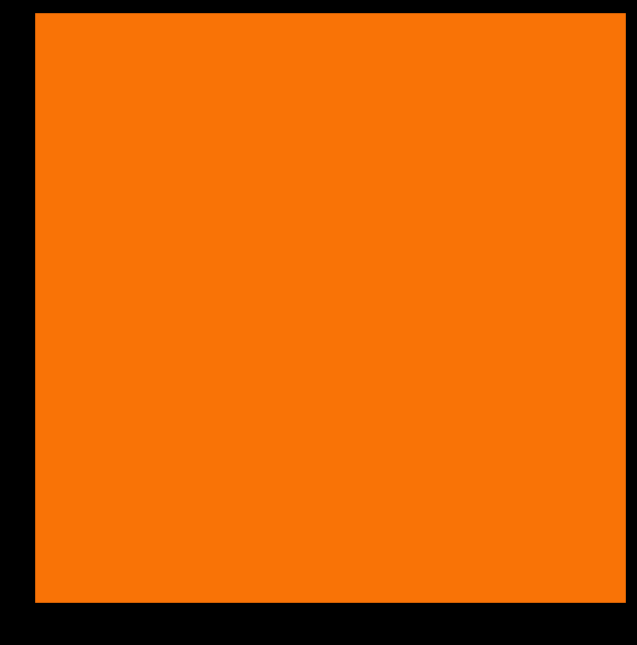

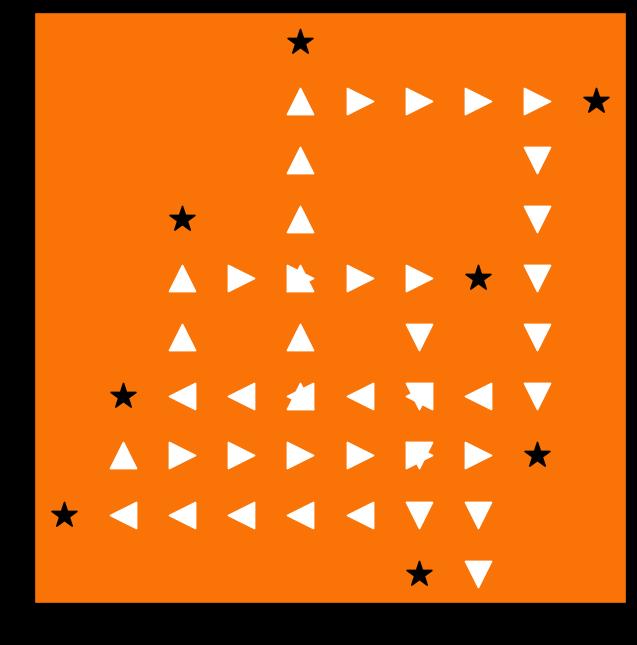

In [21]:
%%time
sample_input = """\
....#.....
.........#
..........
..#.......
.......#..
..........
.#..^.....
........#.
#.........
......#..."""

solve_part1_animated(sample_input.splitlines(), name='anim_2024d06_sample.mp4', fps=15)

### Render the Animation for the Real Input

Careful... With over 4000 frames, this will take a minute.

12:12:57.316:aoc2024 - DBG: Creating the animation. We have 4647 frames to render.
12:12:57.326:aoc2024 - DBG: Rendering frame 0...
12:13:04.584:aoc2024 - DBG: Rendering frame 100...
12:13:16.691:aoc2024 - DBG: Rendering frame 200...
12:13:38.096:aoc2024 - DBG: Rendering frame 300...


KeyboardInterrupt: 

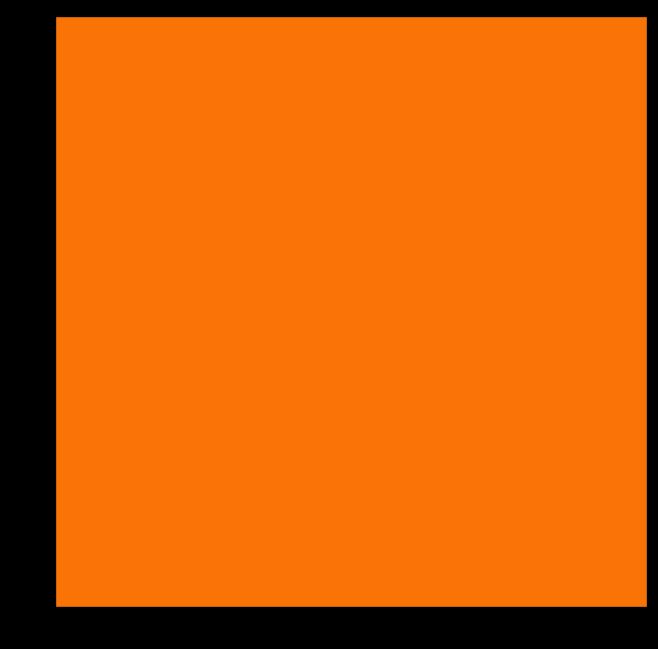

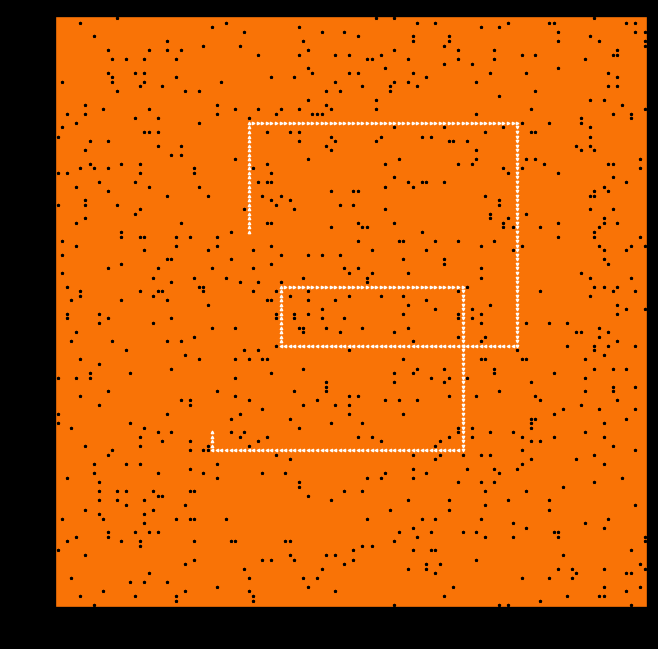

In [22]:
solve_part1_animated(input_data, name='anim_2024d06_real.mp4', fps=25)

### Day 6 Part 2

We need to place a single obstruction that causes the guard to get stuck in a loop! We can place the obstruction at any location apart from the starting point.

**How many different positions could you choose for this obstruction?**

#### Solution Approach

Firstly, we can only put obstructions in the path the guard walks, otherwise it would be pointless. That means >4000 positions to try. Sounds plausible! So my approach is simply to insert this obstacle into the grid, and then perform the walk. We repeat for every possible location, and count how many times this results in a loop.

So:

- Add a method to `reset()` the grid, e.g. the guard starting point, the counters, the direction, etc. This is a little more efficient than creating a new Guard
- Track whether a location has been visited with a given direction in a set. The set will store tuples of `(Point, direction)`. If we try to visit a previously seen configuration, then we're in a loop, so set an attribute to mark that this grid is now in a loop.
- Add a method to add an additional obstacle at a given location. Track the location so that we can clear the obstacle later.
- Add a method to clear the added obstacle.

Now:

- Iterate through all locations in the original loop, as candidates for the obstacle. (Except the starting point.)
- Reset the grid, add the obstacle, and then simulate the guard movement as before.
- With each movement, check if we're in a loop. If so, exit this loop.

This works! But it also takes about 10 seconds to run.  Not the fastest, but not too bad.

In [17]:
def solve_part2(data):
    
    # Initial route
    guard_map = GuardMap(data)
    while guard_map.move():
        pass
    
    # Route taken, excluding starting point
    route = [locn for locn in guard_map.visited.keys()][1:]
    
    loop_locations = 0
    
    for location in tqdm(route):
        guard_map.reset()
        guard_map.add_obstacle(location)
        while guard_map.move():
            if guard_map.in_loop:
                loop_locations += 1
                break
    
    logger.debug(f"Found {loop_locations} loop locations.")
    return loop_locations
            

In [18]:
%%time
sample_inputs = []
sample_inputs.append("""\
....#.....
.........#
..........
..#.......
.......#..
..........
.#..^.....
........#.
#.........
......#...""")
sample_answers = [6]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part2(curr_input.splitlines()), curr_ans) # test with sample data
    logger.info("Test passed")    

logger.info("Tests passed!")

soln = solve_part2(input_data)
logger.info(f"Part 2 soln={soln}")

  0%|          | 0/40 [00:00<?, ?it/s]

12:12:24.967:aoc2024 - DBG: Found 6 loop locations.
12:12:24.969:aoc2024 - INF: Test passed
12:12:24.970:aoc2024 - INF: Tests passed!


  0%|          | 0/4646 [00:00<?, ?it/s]

12:12:42.092:aoc2024 - DBG: Found 1723 loop locations.
12:12:42.094:aoc2024 - INF: Part 2 soln=1723


CPU times: user 15.6 s, sys: 128 ms, total: 15.8 s
Wall time: 17.1 s


---
## Day 7: Bridge Repair

In [ ]:
DAY = "7" # replace with actual number (without leading digit)
show_day_link(DAY)

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2024d01
locations = dc.get_locations(d_name)
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", dc.top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 7 Part 1

Our input data represents equations with operators missing! E.g.

```text
190: 10 19
3267: 81 40 27
83: 17 5
156: 15 6
7290: 6 8 6 15
161011: 16 10 13
192: 17 8 14
21037: 9 7 18 13
292: 11 6 16 20
```

- Operators are always evaluated left-to-right.
- We have two operators to use: `+` and `*`

By inserting operator combinations between numbers, determine which equations could possibly be true. **What is their total calibration result?**

#### Solution Approach

- First, convert the input data into a list of equations. Each equation will be a `tuple` of two parts: the required answer, and the tuple of all the integer numbers (parameters) of our equation.
- For each tuple of numbers on the right of length `n`, there will be `n-1` operators to insert. E.g. with 3 numbers, we need every combination of 2 operators.
- Let's use `itertools.product()` to determine the unique arrangements of `n-1` operators, given two operators. We use `product` because it allows us to repeat an operator. E.g. with `+` and `*` there will be four arrangements: `++`, `+*`, `*+`, and `**`. I'm doing this with a function called `get_op_perms()`.
- I'm also caching this function. I can do this because the operators are always the same, so the arrangements are determnistic for any given required number of operators.

We iterate through each `equation`:

- First we get the arrangements of operators.
- Then we loop through all arrangements of operators. Remember that each arrangement will be a tuple containing exactly the number of operators required between our numbers.
- We apply the operator for each successive pair of numbers, always updating the "left" result such that it becomes the input to the next operation. I could do it like this:

```python
    res = nums[0]  # Initialize with the first number
    for i, op in enumerate(op_perm):
        res = apply_op((res, nums[i + 1]), op)
```

But this is a perfect use case for using the [reduce()](https://aoc.just2good.co.uk/python/map-filter-reduce#reduce) function (aka a "fold"):

```python
    res = reduce(lambda acc, op_and_right: apply_op((acc, op_and_right[1]), op_and_right[0]),
                 zip(op_perm, nums[1:]), # zip the operator with the next number
                 nums[0])  # Start with the first number
```

The `reduce()` function works by applying the specified function successively to every pair of elements in our list. With each iteration, it stores the result in an "aggregator" and then uses this aggregator as the left-hand input to the next iteration.

The lambda function itself defines a function with two parameters: the aggregator, and a tuple which contains the current `(operator, right-number)`. Note that we have to specify the initial value of the aggregator, which is the first number in our list.

(Now I've done this, I think the first approach is more readable.  But oh well!)

This bit is important: **We only require our equation to be valid once. So we should break the loop after adding the equation value to our total.**

I've also created a function for applying the operator, called `apply_op()`. This makes use of the in-built `operator` module, which has a number of fuctions like `add()`, `mul()`, etc. This is useful because we can pick the appropriate function based on the `op` string, and pass our two numbers in as parameters to each of these functions.

In [ ]:
def process_input(data) -> list[tuple]:
    """ Return equations in the form: [(answer, numbers), ...] """
    equations = []
    for line in data:
        ans, nums = line.split(":")
        ans = int(ans)
        nums = list(map(int, nums.split()))
        equations.append((ans, nums))
        
    return equations

@cache
def get_op_perms(ops: str, num_parameters: int):
    """ 
    Return all the ways of ordering our operators for a given number of parameters.
    E.g. if ops == "+*" and there are 3 parameters, then we need all permutations of 2 operators: 
    [("+", "+"), ("+", "*"), ("*", "+"), ("*", "*")]
    """
    op_perms = list(product(ops, repeat=num_parameters-1))
    logger.debug(f"Number of op perms with {num_parameters-1} insertions: {len(op_perms)}")
    return op_perms
    
def apply_op(num_pair: tuple[int], op: str) -> int:
    match op: # Note Python's implementatiom of switch
        case "+":
            return operator.add(*num_pair)
        case "*":
            return operator.mul(*num_pair)
        case "|":
            return int("".join(str(num) for num in num_pair))
        case _:
            raise ValueError(f"Unknown operator: {op}")
    

In [ ]:
def solve(data, ops):
    equations = process_input(data) # [0] is the ans; [1] are the numbers
    total = 0
    
    for equation in tqdm(equations):
        nums = equation[1]
        
        # get a list of operator combinations, with each element being of length n-1
        # E.g. with 3 numbers, we'll get: [('+', '+'), ('+', '*'), ('*', '+'), ('*', '*')]
        op_perms = get_op_perms(ops, len(nums))

        for op_perm in op_perms: # a tuple of operators of length n-1
            ans = reduce(lambda acc, op_and_right: apply_op((acc, op_and_right[1]), op_and_right[0]),
                         zip(op_perm, nums[1:]), # zip the operator with the next number
                         nums[0])  # Start with the first number

            if ans == equation[0]:
                total += equation[0] 
                break # we only need one successful result per equestion
         
    return total
    

In [ ]:
%%time
sample_inputs = []
sample_inputs.append("""\
190: 10 19
3267: 81 40 27
83: 17 5
156: 15 6
7290: 6 8 6 15
161011: 16 10 13
192: 17 8 14
21037: 9 7 18 13
292: 11 6 16 20""")
sample_answers = [3749]

OPERATORS = "+*"

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve(curr_input.splitlines(), OPERATORS), curr_ans) # test with sample data
    logger.info("Test passed")

logger.info("All tests passed!")

soln = solve(input_data, OPERATORS)
logger.info(f"Part 1 soln={soln}")

### Day 7 Part 2

Oh, surprise.  There's a third operator. The op `||` combines digits from left and right into a single number. E.g. `12 || 345` results in `12345`.

#### Solution Approach

It's dead easy to incorporate this. I've just added a new operator to my `apply_op()` function. However, rather than calling it `||`, I've called it `|`. This way, I can just include it in my string of operators: `+*|`.

Of course this means that we'll get a lot more arrangements of operators. E.g.

| Number of Op Insertions | Arrangements with 2 operators | Arrangements with 3 operators |
|---|--|---|
| 1 | 2 | 3 |
| 2 | 4 | 9 |
| 3 | 8 | 27 |
| 4 | 16 | 81 |
| 5 | 32 | 243 |
| 6 | 64 | 729 |

So it takes a little while to run. On my laptop this is taking 12 seconds.

In [ ]:
%%time
sample_inputs = []
sample_inputs.append("""\
190: 10 19
3267: 81 40 27
83: 17 5
156: 15 6
7290: 6 8 6 15
161011: 16 10 13
192: 17 8 14
21037: 9 7 18 13
292: 11 6 16 20""")
sample_answers = [11387]

OPERATORS = "+*|"

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve(curr_input.splitlines(), OPERATORS), curr_ans) # test with sample data
    logger.info("Test passed")

logger.info("All tests passed!")

soln = solve(input_data, OPERATORS)
logger.info(f"Part 1 soln={soln}")

---
## Day 8: Resonant Collinearity

In [ ]:
DAY = "8" # replace with actual number (without leading digit)
show_day_link(DAY)

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2024d01
locations = dc.get_locations(d_name)
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", dc.top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 8 Part 1

Our grid represents a city containing antennae. Each antenna is tuned to a particular frequency given by a single lowercase letter, uppercase letter, or digit. E.g.

```text
............
........0...
.....0......
.......0....
....0.......
......A.....
............
............
........A...
.........A..
............
............
```

- _Antinodes_ are created at any point where two antenna of the same frequenty are aligned, but where one is twice as far away as other. 
- This means that for any pair of antennas with the same frequency, there are two antinodes, one on either side of them.
- An antinode can _can_ occur at locations that contain antennae.

**How many unique locations within the bounds of the map contain an antinode?**

I'm going to extend my `Grid` class again, to make a `NodeGrid` class.

We start by initialing a dictionary containing a set of locations for each antenna when find. Use a `defaultdict(set)` for this, so that we can just add a location, every time we find one for a given frequency.

Next, the heart of the problem: my `_update_antinodes()` method:

- First, we retrieve the set of antennae locations for a given frequency.
- Then, we determine all the pairs of locations for this frequency. Note that these are edges in an undirected graph. The number of edges for a given number of antennae will be:

$$
  p = \frac{n(n-1)}{2} 
$$

E.g.

| Number of Antennae | Number of Edges |
|---|---|
| 1 | 0 |
| 2 | 1 |
| 3 | 3 |
| 4 | 6 |
| 5 | 10 |

(Oooh look! Triangle numbers!)

For each pair, I determine the vector between the points. This is my `delta`.

Now, to determine the required antinode locations, we need to find the locations that are exactly one delta before the pair, and one delta after the pair. E.g. for two points `X` and `Y`, our antinodes will be found at:

`------*----X----Y----*-----------`

We can do this by subtracting the delta from `X`, and by adding the delta to `Y`. Or, perhaps more reusable (and this turns out to be quite useful in Part 2!), we can just add two vectors to `X`:

1. Add `-1 * delta`
1. Add `2 * delta`

Each time we add our required number of deltas, check if the new location is within our grid.  If it is, we've found an antinode and we add it to our `_antinodes` set.

Pretty simple!

In [ ]:
class NodeGrid(Grid):
    def __init__(self, grid_array):
        super().__init__(grid_array)
        
        self._antennae_by_freq: dict[str, set[Point]] = defaultdict(set)
        self._populate_antennae()
        
        self._antinodes: set[Point] = set()
    
    @property
    def antinodes(self):
        return self._antinodes
    
    def _populate_antennae(self):
        """ Populate our dict of antennae locations, as { freq: (loc1, loc2...), freq: (loc1, loc2...), ... }"""
        for point in self._all_points:
            val = self.value_at_point(point)
            if val != ".":
                self._antennae_by_freq[val].add(point)
        
        for freq, locations in self._antennae_by_freq.items():
            logger.debug(f"{freq=},{locations=}")
                
    def update_antinodes(self, resonant=False):
        """ Find antinodes.
        If resonant, these are any multiples of the distance between two nodes
        including the nodes themselves.
        Otherwise, just one antinode either side of our pair. """
        
        for antenna_freq in self._antennae_by_freq.keys(): # a frequency
            antennae = self._antennae_by_freq[antenna_freq]
            
            if resonant:
                # If there are more than two antennae, these will be part of the resonant node set
                if len(antennae) > 1:
                    self._antinodes.update(antennae)                
            
            # Get all the undirected edges between these frequencies
            edges = list(combinations(antennae, 2))
            
            # For each edge, calculate the antinodes
            for edge in edges:
                delta: Point = edge[1] - edge[0]
                
                for sign in [-1, 1]:
                    delta_multiple = 2 if sign == 1 else -1
                    
                    while True:
                        an = edge[0] + Point(delta_multiple*delta.x, 
                                             delta_multiple*delta.y)
                        
                        # Check not outside of grid
                        if self.valid_location(an):
                            self._antinodes.add(an)
                        else:
                            break # We can't go further in this direction
                        
                        if not resonant:
                            break # We only want the first delta in this direction
                        else:
                            delta_multiple += sign
            
    def __str__(self) -> str:
        """ Render the grid. Antinodes are shown in yellow. """
        row_strs = []
        for y, row in enumerate(self._array):
            row_list = [] if y > 0 else [Fore.RESET]  # Build a list of characters for each row
            for x, char in enumerate(row):
                if Point(x, y) in self._antinodes:
                    row_list.append(Fore.YELLOW)
                    row_list.extend(["*" if char == "." else char])
                    row_list.append(Fore.RESET)
                else:
                    row_list.append(char)
            row_strs.append("".join(row_list))  # Efficiently join the characters

        return "\n".join(row_strs) # and the rows        
          
        

In [ ]:
def solve_part1(data):
    node_grid = NodeGrid(data)
    node_grid.update_antinodes()
    logger.debug(f"\n{node_grid}")
    
    return len(node_grid.antinodes)

In [ ]:
%%time
sample_inputs = []
sample_inputs.append("""\
............
........0...
.....0......
.......0....
....0.......
......A.....
............
............
........A...
.........A..
............
............""")
sample_answers = [14]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part1(curr_input.splitlines()), curr_ans) # test with sample data
    logger.info("Test passed")

logger.info("All tests passed!")

soln = solve_part1(input_data)
logger.info(f"Part 1 soln={soln}")

### Day 8 Part 2

Now we're told that: _"an antinode occurs at any grid position exactly in line with at least two antennas of the same frequency, regardless of distance."_

Actually, what this means is that an antinode can appear at any integer multiple of the distance. E.g.

`-*----*----X----Y----*----*----*-`

**Important point: the `X` and `Y` are now also antinodes.**

#### Solution Approach

This is a trivial tweak to my code for part 1. First, let's add a parameter to the function to determine if we're in `resonant` mode or not.

And now, instead of just adding deltas `-1` and `2`, I now just add `n` deltas, until the resulting location is out of the grid. I also iterate through signs `[-1, 1]` to determine how to increment the `delta_multiple`, and also to determine where to start, i.e. `-1` or `2` respectively. 

Also, if we're in `resonant` mode, we mustn't forget to the antennae locations to our set.

And that's it!

In [ ]:
def solve_part2(data):
    node_grid = NodeGrid(data)
    node_grid.update_antinodes(resonant=True)
    logger.debug(f"\n{node_grid}")
    
    return len(node_grid.antinodes)

In [ ]:
%%time
sample_inputs = []
sample_inputs.append("""\
............
........0...
.....0......
.......0....
....0.......
......A.....
............
............
........A...
.........A..
............
............""")
sample_answers = [34]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part2(curr_input.splitlines()), curr_ans) # test with sample data
    logger.info("Test passed")    

logger.info("Tests passed!")

soln = solve_part2(input_data)
logger.info(f"Part 2 soln={soln}")

---
## Day 9: title

In [ ]:
DAY = "9" # replace with actual number (without leading digit)
show_day_link(DAY)

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2024d01
locations = dc.get_locations(d_name)
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", dc.top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 9 Part 1

Overview...

In [ ]:
def solve_part1(data):
    pass

In [ ]:
%%time
sample_inputs = []
sample_inputs.append("""abcdef""")
sample_answers = ["uvwxyz"]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part1(curr_input), curr_ans) # test with sample data
    logger.info("Test passed")

logger.info("All tests passed!")

soln = solve_part1(input_data)
logger.info(f"Part 1 soln={soln}")

### Day 9 Part 2

Overview...

In [ ]:
def solve_part2(data):
    pass

In [ ]:
%%time
sample_inputs = []
sample_inputs.append("""abcdef""")
sample_answers = ["uvwxyz"]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part2(curr_input), curr_ans) # test with sample data
    logger.info("Test passed")    

logger.info("Tests passed!")

soln = solve_part2(input_data)
logger.info(f"Part 2 soln={soln}")

---
## Day n: title

In [ ]:
DAY = "n" # replace with actual number (without leading digit)
show_day_link(DAY)

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2024d01
locations = dc.get_locations(d_name)
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", dc.top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day n Part 1

Overview...

In [ ]:
def solve_part1(data):
    pass

In [ ]:
%%time
sample_inputs = []
sample_inputs.append("""abcdef""")
sample_answers = ["uvwxyz"]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part1(curr_input), curr_ans) # test with sample data
    logger.info("Test passed")

logger.info("All tests passed!")

soln = solve_part1(input_data)
logger.info(f"Part 1 soln={soln}")

### Day n Part 2

Overview...

In [ ]:
def solve_part2(data):
    pass

In [ ]:
%%time
sample_inputs = []
sample_inputs.append("""abcdef""")
sample_answers = ["uvwxyz"]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part2(curr_input), curr_ans) # test with sample data
    logger.info("Test passed")    

logger.info("Tests passed!")

soln = solve_part2(input_data)
logger.info(f"Part 2 soln={soln}")